# Diabetes 130 US hospitals for years 1999-2008 (Diabetes - readmission)
## Modelling
* In this notebook, I have trained final dataset obtained after preprocessing. 
* Our main metric to for comparision will be "f1_score".
* We will take two cases, one with the texts and other without texts.
* In the case with the texts, i will use Bag of words (BoW) and TfIDF vectorizers.
* We will train 4 models- Logistic Regression, Decision Tree, Random Forest and XGBoost.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
import pickle
from tqdm import tqdm
import os
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/MyDrive/preprocessed_2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_des,diag_2_des,diag_3_des,disch_description,admit_description,procedure_per_med,num_med_up,num_med_used,count_encounter
0,0,0,2278392,8222157,Caucasian,Female,5.0,6,25,1,1,41,0,1,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,Diabetes with other specified manifestations t...,diabetes mellitus,diabetes mellitus,Reserved National Assignment,Physician Referral,41.000000,0,0,1
1,1,1,149190,55629189,Caucasian,Female,15.0,1,1,7,3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Disorders of fluid electrolyte and acid-base b...,Diabetes mellitus without mention of complicat...,Disorders of adrenal glands,Discharged home self care routine charge,Emergency Room,3.277778,1,1,1
2,2,2,64410,86047875,AfricanAmerican,Female,25.0,1,1,7,2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Other current conditions in the mother classif...,diabetes mellitus,Outcome of delivery,Discharged home self care routine charge,Emergency Room,1.230769,0,1,1
3,3,3,500364,82442376,Caucasian,Male,35.0,1,1,7,2,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Intestinal infections due to other organisms,Diabetes with renal manifestations type I [juv...,Hypertensive chronic kidney disease,Discharged home self care routine charge,Emergency Room,2.812500,1,1,1
4,4,4,16680,42519267,Caucasian,Male,45.0,1,1,7,1,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Secondary malignant neoplasm of respiratory an...,Malignant neoplasm of pancreas,diabetes mellitus,Discharged home self care routine charge,Emergency Room,6.375000,0,2,1


In [4]:
def label(x):
    if x=='NO' or x=='>30':
        return 0
    elif x=='<30':
        return 1
df['readmitted'] = df['readmitted'].apply(label)

In [ ]:
df['readmitted'].value_counts()

0    90407
1    11357
Name: readmitted, dtype: int64

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'encounter_id', 'patient_nbr', 'race',
       'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_des', 'diag_2_des', 'diag_3_des', 'disch_description',
       'admit_description', 'procedure_per_med', 'num_med_up', 'num_med_us

In [ ]:
df.shape

(101764, 55)

### Encoding Categorical features
***'gender','race', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','change', 'diabetesMed'    ***

In [5]:
from sklearn.preprocessing import OneHotEncoder

df_dum = pd.get_dummies(df, columns=['gender','race', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                                     'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
                                     'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
                                     'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 
                                     'change', 'diabetesMed','change', 'diabetesMed' ])


In [ ]:
df_dum.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'encounter_id', 'patient_nbr', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures',
       ...
       'metformin-pioglitazone_No', 'metformin-pioglitazone_Steady',
       'change_Ch', 'change_No', 'diabetesMed_No', 'diabetesMed_Yes',
       'change_Ch', 'change_No', 'diabetesMed_No', 'diabetesMed_Yes'],
      dtype='object', length=121)

In [ ]:
print("Shape of dummy features for all categoricalape of dummy features for all categorical features: (101764, 121) features:",df_dum.shape)

Shape of dummy features for all categorical features: (101764, 121)


In [ ]:
df_dum.head()

,Unnamed: 0,Unnamed: 0.1,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,diag_1_des,diag_2_des,diag_3_des,disch_description,admit_description,procedure_per_med,num_med_up,num_med_used,count_encounter,gender_Female,gender_Male,gender_Unknown/Invalid,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,...,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0,0,2278392,8222157,5.0,6,25,1,1,41,0,1,0,0,0,1,0,Diabetes with other specified manifestations t...,diabetes mellitus,diabetes mellitus,Reserved National Assignment,Physician Referral,41.000000,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0
1,1,1,149190,55629189,15.0,1,1,7,3,59,0,18,0,0,0,9,0,Disorders of fluid electrolyte and acid-base b...,Diabetes mellitus without mention of complicat...,Disorders of adrenal glands,Discharged home self care routine charge,Emergency Room,3.277778,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1
2,2,2,64410,86047875,25.0,1,1,7,2,11,5,13,2,0,1,6,0,Other current conditions in the mother classif...,diabetes mellitus,Outcome of delivery,Discharged home self care routine charge,Emergency Room,1.230769,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1
3,3,3,500364,82442376,35.0,1,1,7,2,44,1,16,0,0,0,7,0,Intestinal infections due to other organisms,Diabetes with renal manifestations type I [juv...,Hypertensive chronic kidney disease,Discharged home self care routine charge,Emergency Room,2.812500,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1
4,4,4,16680,42519267,45.0,1,1,7,1,51,0,8,0,0,0,5,0,Secondary malignant neoplasm of respiratory an...,Malignant neoplasm of pancreas,diabetes mellitus,Discharged home self care routine charge,Emergency Room,6.375000,0,2,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1


## Engineering Text Features

***'diag_1_des', 'diag_2_des', 'diag_3_des', 'disch_description','admit_description'***

In [6]:
df_dum['text'] = df_dum['diag_1_des'].map(str)+ ' ' +df_dum['diag_2_des'].map(str)+ ' ' + df_dum['diag_3_des'].map(str)+ ' ' +df_dum['disch_description'].map(str)+ ' ' +df_dum[ 'admit_description'].map(str)

In [7]:
df_dum.head()

,Unnamed: 0,Unnamed: 0.1,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,diag_1_des,diag_2_des,diag_3_des,disch_description,admit_description,procedure_per_med,num_med_up,num_med_used,count_encounter,gender_Female,gender_Male,gender_Unknown/Invalid,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,...,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,text
0,0,0,2278392,8222157,5.0,6,25,1,1,41,0,1,0,0,0,1,0,Diabetes with other specified manifestations t...,diabetes mellitus,diabetes mellitus,Reserved National Assignment,Physician Referral,41.000000,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,Diabetes with other specified manifestations t...
1,1,1,149190,55629189,15.0,1,1,7,3,59,0,18,0,0,0,9,0,Disorders of fluid electrolyte and acid-base b...,Diabetes mellitus without mention of complicat...,Disorders of adrenal glands,Discharged home self care routine charge,Emergency Room,3.277778,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,Disorders of fluid electrolyte and acid-base b...
2,2,2,64410,86047875,25.0,1,1,7,2,11,5,13,2,0,1,6,0,Other current conditions in the mother classif...,diabetes mellitus,Outcome of delivery,Discharged home self care routine charge,Emergency Room,1.230769,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,Other current conditions in the mother classif...
3,3,3,500364,82442376,35.0,1,1,7,2,44,1,16,0,0,0,7,0,Intestinal infections due to other organisms,Diabetes with renal manifestations type I [juv...,Hypertensive chronic kidney disease,Discharged home self care routine charge,Emergency Room,2.812500,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,Intestinal infections due to other organisms D...
4,4,4,16680,42519267,45.0,1,1,7,1,51,0,8,0,0,0,5,0,Secondary malignant neoplasm of respiratory an...,Malignant neoplasm of pancreas,diabetes mellitus,Discharged home self care routine charge,Emergency Room,6.375000,0,2,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,Secondary malignant neoplasm of respiratory an...


In [8]:
df_dum = df_dum.drop(['diag_1_des', 'diag_2_des', 'diag_3_des', 'disch_description','admit_description'],axis=1)
df_dum.head()

,Unnamed: 0,Unnamed: 0.1,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,procedure_per_med,num_med_up,num_med_used,count_encounter,gender_Female,gender_Male,gender_Unknown/Invalid,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,...,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,text
0,0,0,2278392,8222157,5.0,6,25,1,1,41,0,1,0,0,0,1,0,41.000000,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,Diabetes with other specified manifestations t...
1,1,1,149190,55629189,15.0,1,1,7,3,59,0,18,0,0,0,9,0,3.277778,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,Disorders of fluid electrolyte and acid-base b...
2,2,2,64410,86047875,25.0,1,1,7,2,11,5,13,2,0,1,6,0,1.230769,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,Other current conditions in the mother classif...
3,3,3,500364,82442376,35.0,1,1,7,2,44,1,16,0,0,0,7,0,2.812500,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,Intestinal infections due to other organisms D...
4,4,4,16680,42519267,45.0,1,1,7,1,51,0,8,0,0,0,5,0,6.375000,0,2,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,Secondary malignant neoplasm of respiratory an...


In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re
from tqdm import tqdm
def text_preprocess(phrase):
    preprocessed_text = []

    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = phrase.replace('(','')
    phrase = phrase.replace(')' ,'')
    phrase = phrase.replace('.' ,'')                            
    phrase = phrase.replace('-' ,'')
    phrase = phrase.replace(':' ,'')  
    phrase = phrase.replace('/',' ')
    phrase = phrase.replace('[',' ')
    phrase = phrase.replace(']',' ')
                            

    phrase = ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)

    preprocessed_text.append(phrase.lower().strip())
    return phrase



In [11]:
df_dum['text'] = df_dum['text'].apply(text_preprocess)

In [12]:
df_dum.isnull().sum()

Unnamed: 0         0
Unnamed: 0.1       0
encounter_id       0
patient_nbr        0
age                0
                  ..
change_Ch          0
change_No          0
diabetesMed_No     0
diabetesMed_Yes    0
text               0
Length: 117, dtype: int64

In [13]:
df_dum = df_dum.dropna()

In [14]:


from sklearn.model_selection import train_test_split

X = df_dum.drop(['Unnamed: 0', 'Unnamed: 0.1', 'encounter_id', 'patient_nbr','readmitted' ], axis=1)
y = df_dum['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.3, stratify = y_train)

In [ ]:
print('SHAPES:-')
print('-'*50)
print('x_train: ',X_train.shape)
print('x_test: ',X_test.shape)
print('-'*50)
print('Percent share of data:-')
print('-'*50)
print('x_train: ', X_train.shape[0]*100/(X_train.shape[0] +X_test.shape[0]))
print('x_test: ', X_test.shape[0]*100/(X_train.shape[0]  + X_test.shape[0]))

SHAPES:-
--------------------------------------------------
x_train:  (71234, 112)
x_test:  (30530, 112)
--------------------------------------------------
Percent share of data:-
--------------------------------------------------
x_train:  69.99921386737942
x_test:  30.000786132620572


### Encoding Text features

In [15]:
lst_features = []

### Set 1 (Bag of Words)

In [ ]:
vect = CountVectorizer(min_df=10, ngram_range = (1,4), max_features = 100)
X_train_txt_bow = vect.fit_transform(X_train['text'].values)
X_test_txt_bow = vect.transform(X_test['text'].values)
lst_features.extend(vect.get_feature_names())

#printing the shapes:
print('x_train_text_bow: ',X_train_txt_bow.shape)
#print('x_cv_text: ',X_cv_txt_bow.shape)
print('x_test_text_bow: ',X_test_txt_bow.shape)
#print('='*50)
#print('length of feature list:',len(lst_features))

x_train_text_bow:  (71234, 100)
x_test_text_bow:  (30530, 100)


### Set 2 (Tfidf)

In [ ]:
vect = TfidfVectorizer(min_df=10, ngram_range = (1,4), max_features = 100)
#fitting the vectorizer on X_train only
X_train_txt_tf = vect.fit_transform(X_train['text'].values)
lst_features.extend(vect.get_feature_names())
# now, finding the bag of words for all sets:
#X_train_txt_tf = vect.transform(X_train['text'].values)
#X_cv_txt_tf = vect.transform(X_cv['text'].values)
X_test_txt_tf = vect.transform(X_test['text'].values)

#printing the shapes:
print('x_txt_tfidf: ',X_train_txt_tf.shape)
#print('x_cv_txt: ',X_cv_txt_tf.shape)
print('x_test_txt: ',X_test_txt_tf.shape)
#print('='*50)
#print('length of feature list:',len(lst_features))

x_txt_tfidf:  (71234, 100)
x_test_txt:  (30530, 100)


### Encoding Numerical Features
***'age','time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses' ***

In [16]:
from sklearn.preprocessing import Normalizer

#age
norm = Normalizer().fit(X_train['age'].values.reshape(1,-1))
X_train_age = norm.transform(X_train['age'].values.reshape(1,-1)).reshape(-1,1)
X_test_age = norm.transform(X_test['age'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_age = norm.transform(X_cv['age'].values.reshape(1,-1)).reshape(-1,1)

#time_in_hospital
norm = Normalizer().fit(X_train['time_in_hospital'].values.reshape(1,-1))
X_train_time_in_hospital = norm.transform(X_train['time_in_hospital'].values.reshape(1,-1)).reshape(-1,1)
X_test_time_in_hospital = norm.transform(X_test['time_in_hospital'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_time_in_hospital = norm.transform(X_cv['time_in_hospital'].values.reshape(1,-1)).reshape(-1,1)

#'num_lab_procedures'
norm = Normalizer().fit(X_train['num_lab_procedures'].values.reshape(1,-1))
X_train_num_lab_procedures = norm.transform(X_train['num_lab_procedures'].values.reshape(1,-1)).reshape(-1,1)
X_test_num_lab_procedures = norm.transform(X_test['num_lab_procedures'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_num_lab_procedures = norm.transform(X_cv['num_lab_procedures'].values.reshape(1,-1)).reshape(-1,1)

# 'num_procedures'
norm = Normalizer().fit(X_train['num_procedures'].values.reshape(1,-1))
X_train_num_procedures = norm.transform(X_train['num_procedures'].values.reshape(1,-1)).reshape(-1,1)
X_test_num_procedures = norm.transform(X_test['num_procedures'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_num_procedures = norm.transform(X_cv['num_procedures'].values.reshape(1,-1)).reshape(-1,1)

#'num_medications'
norm = Normalizer().fit(X_train['num_medications'].values.reshape(1,-1))
X_train_num_medications = norm.transform(X_train['num_medications'].values.reshape(1,-1)).reshape(-1,1)
X_test_num_medications = norm.transform(X_test['num_medications'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_num_medications = norm.transform(X_cv['num_medications'].values.reshape(1,-1)).reshape(-1,1)

#'number_outpatient'
norm = Normalizer().fit(X_train['number_outpatient'].values.reshape(1,-1))
X_train_number_outpatient = norm.transform(X_train['number_outpatient'].values.reshape(1,-1)).reshape(-1,1)
X_test_number_outpatient = norm.transform(X_test['number_outpatient'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_number_outpatient = norm.transform(X_cv['number_outpatient'].values.reshape(1,-1)).reshape(-1,1)

#'number_emergency'
norm = Normalizer().fit(X_train['number_emergency'].values.reshape(1,-1))
X_train_number_emergency = norm.transform(X_train['number_emergency'].values.reshape(1,-1)).reshape(-1,1)
X_test_number_emergency = norm.transform(X_test['number_emergency'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_number_emergency = norm.transform(X_cv['number_emergency'].values.reshape(1,-1)).reshape(-1,1)


#'number_inpatient'
norm = Normalizer().fit(X_train['number_inpatient'].values.reshape(1,-1))
X_train_number_inpatient = norm.transform(X_train['number_inpatient'].values.reshape(1,-1)).reshape(-1,1)
X_test_number_inpatient = norm.transform(X_test['number_inpatient'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_number_inpatient = norm.transform(X_cv['number_inpatient'].values.reshape(1,-1)).reshape(-1,1)



#'number_diagnoses' 
norm = Normalizer().fit(X_train['number_diagnoses'].values.reshape(1,-1))
X_train_number_diagnoses = norm.transform(X_train['number_diagnoses'].values.reshape(1,-1)).reshape(-1,1)
X_test_number_diagnoses = norm.transform(X_test['number_diagnoses'].values.reshape(1,-1)).reshape(-1,1)
#X_cv_number_diagnoses = norm.transform(X_cv['number_diagnoses'].values.reshape(1,-1)).reshape(-1,1)

### Concatenation (BOW)

In [ ]:
X_train.head()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,procedure_per_med,num_med_up,num_med_used,count_encounter,gender_Female,gender_Male,gender_Unknown/Invalid,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,...,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,text
35582,85.0,1,3,7,3,43,0,9,0,0,0,9,4.777778,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,acute illdefined cerebrovascular disease cereb...
55196,65.0,1,1,7,2,66,1,13,0,0,1,9,5.153846,0,3,3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,septicemia acute kidney failure diabetes renal...
47517,75.0,1,1,7,2,43,0,16,0,0,0,7,2.687500,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,symptoms involving respiratory system chest sy...
91186,55.0,2,1,7,8,74,0,28,0,1,1,9,2.642857,0,3,3,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,pneumonia organism unspecified chronic bronchi...
42131,25.0,1,7,7,1,25,0,7,0,5,3,2,3.571429,1,1,12,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,diabetes ketoacidosis type juvenile type not s...


In [17]:
X_train_categorical = X_train.drop(['age','time_in_hospital', 'num_lab_procedures', 'num_procedures',
                                    'num_medications', 'number_outpatient', 'number_emergency',
                                    'number_inpatient', 'number_diagnoses', 'text'], axis=1)
X_test_categorical = X_test.drop(['age','time_in_hospital', 'num_lab_procedures', 'num_procedures',
                                    'num_medications', 'number_outpatient', 'number_emergency',
                                    'number_inpatient', 'number_diagnoses', 'text'], axis=1)
#X_cv_categorical = X_cv.drop(['age','time_in_hospital', 'num_lab_procedures', 'num_procedures',
#                                    'num_medications', 'number_outpatient', 'number_emergency',
#                                    'number_inpatient', 'number_diagnoses', 'text'], axis=1)

In [ ]:
X_train_categorical.shape

(71234, 102)

### Concatenation including text (BoW)

In [ ]:
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_categorical, X_train_txt_bow, X_train_age, X_train_time_in_hospital, X_train_num_lab_procedures,
                  X_train_num_procedures, X_train_num_medications, X_train_number_outpatient, X_train_number_emergency,
                  X_train_number_inpatient, X_train_number_diagnoses )).tocsr()
#X_cr_bow = hstack(( X_cv_categorical, X_cv_txt_bow, X_cv_age, X_cv_time_in_hospital, X_cv_num_lab_procedures,
#                  X_cv_num_procedures, X_cv_num_medications, X_cv_number_outpatient, X_cv_number_emergency,
#                  X_cv_number_inpatient, X_cv_number_diagnoses )).tocsr()
X_te_bow = hstack(( X_test_categorical, X_test_txt_bow, X_test_age, X_test_time_in_hospital, X_test_num_lab_procedures,
                  X_test_num_procedures, X_test_num_medications, X_test_number_outpatient, X_test_number_emergency,
                  X_test_number_inpatient, X_test_number_diagnoses )).tocsr()

print("Final Data matrix")
print(X_tr_bow.shape, y_train.shape)
#print(X_cr_bow.shape, y_cv.shape)
print(X_te_bow.shape, y_test.shape)
print("="*100)

Final Data matrix
(71234, 211) (71234,)
(30530, 211) (30530,)


### Concatenation including text (TfIDF)

In [ ]:
from scipy.sparse import hstack
X_tr_tf = hstack((X_train_categorical, X_train_txt_tf, X_train_age, X_train_time_in_hospital, X_train_num_lab_procedures,
                  X_train_num_procedures, X_train_num_medications, X_train_number_outpatient, X_train_number_emergency,
                  X_train_number_inpatient, X_train_number_diagnoses )).tocsr()
#X_cr_tf = hstack(( X_cv_categorical, X_cv_txt_tf, X_cv_age, X_cv_time_in_hospital, X_cv_num_lab_procedures,
#                  X_cv_num_procedures, X_cv_num_medications, X_cv_number_outpatient, X_cv_number_emergency,
#                  X_cv_number_inpatient, X_cv_number_diagnoses )).tocsr()
X_te_tf = hstack(( X_test_categorical, X_test_txt_tf, X_test_age, X_test_time_in_hospital, X_test_num_lab_procedures,
                  X_test_num_procedures, X_test_num_medications, X_test_number_outpatient, X_test_number_emergency,
                  X_test_number_inpatient, X_test_number_diagnoses )).tocsr()

print("Final Data matrix")
print(X_tr_tf.shape, y_train.shape)
#print(X_cr_tf.shape, y_cv.shape)
print(X_te_tf.shape, y_test.shape)
print("="*100)

Final Data matrix
(71234, 211) (71234,)
(30530, 211) (30530,)


### Concatenation without text

In [ ]:
from scipy.sparse import hstack
X_tr = np.hstack((X_train_categorical, X_train_age, X_train_time_in_hospital, X_train_num_lab_procedures,
              X_train_num_procedures, X_train_num_medications, X_train_number_outpatient, X_train_number_emergency,
              X_train_number_inpatient, X_train_number_diagnoses))
#X_cr_tf = hstack(( X_cv_categorical, X_cv_txt_tf, X_cv_age, X_cv_time_in_hospital, X_cv_num_lab_procedures,
#                  X_cv_num_procedures, X_cv_num_medications, X_cv_number_outpatient, X_cv_number_emergency,
#                  X_cv_number_inpatient, X_cv_number_diagnoses )).tocsr()
X_te = np.hstack(( X_test_categorical, X_test_age, X_test_time_in_hospital, X_test_num_lab_procedures,
                  X_test_num_procedures, X_test_num_medications, X_test_number_outpatient, X_test_number_emergency,
                  X_test_number_inpatient, X_test_number_diagnoses ))

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
#print(X_cr_tf.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(71234, 111) (71234,)
(30530, 111) (30530,)


# Modelling

In [18]:
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [19]:
#ref: https://www.kaggle.com/qianchao/smote-with-imbalance-data
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Logistic reg without text

In [ ]:
from imblearn.over_sampling import SMOTE
#ref: https://www.kaggle.com/qianchao/smote-with-imbalance-data
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_tr, y_train.ravel())


print('After SMOTE, the shape of train_X: {}'.format(X_train_res.shape))
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After SMOTE, counts of label '1': {}".format(sum(y_train_res==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 7950
Before OverSampling, counts of label '0': 63284 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE, the shape of train_X: (126568, 111)
After SMOTE, the shape of train_y: (126568,) 

After SMOTE, counts of label '1': 63284
After SMOTE, counts of label '0': 63284


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report, f1_score


lr = LogisticRegression(fit_intercept=True).fit(X_train_res, y_train_res)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Roc-Auc : 0.70
Accuracy : 0.73
Precision : 0.22
Recall : 0.55
Macro f1 : 0.57


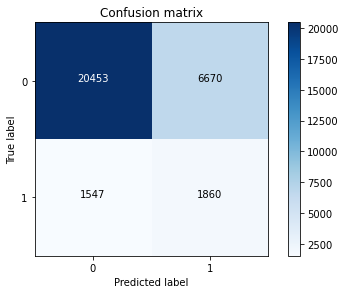

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_test_pred = lr.predict(X_te)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = lr.predict_proba(X_te)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))
print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Decision Tree without text

Roc-Auc : 0.48
Accuracy : 0.25
Precision : 0.11
Recall : 0.79
Macro f1 : 0.25


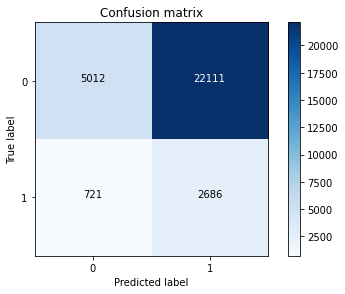

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dt.fit(X_train_res, y_train_res)


y_test_pred = dt.predict(X_te)

c_matrix_test = confusion_matrix(y_test, y_test_pred)
y_test_score = dt.predict_proba(X_te)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Random Forest without text

Roc-Auc : 0.66
Accuracy : 0.79
Precision : 0.20
Recall : 0.28
Macro f1 : 0.56


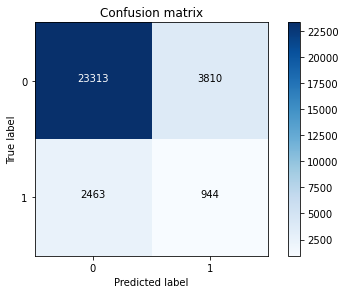

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf.fit(X_train_res, y_train_res)

y_test_pred = rf.predict(X_te)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = rf.predict_proba(X_te)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### XGBoost without text

Roc-Auc : 0.61
Accuracy : 0.43
Precision : 0.14
Recall : 0.77
Macro f1 : 0.39


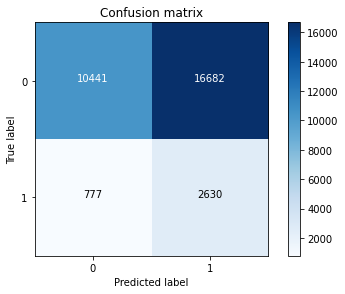

In [ ]:
import xgboost as xgb
xg = xgb.XGBClassifier(learning_rate=0.25, n_estimators=84)
xg.fit(X_train_res, y_train_res)

y_test_pred = xg.predict(X_te)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = xg.predict_proba(X_te)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Logistic reg with BOW

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

lr = LogisticRegression(fit_intercept=True).fit(X_tr_bow, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Roc-Auc : 0.71
Accuracy : 0.89
Precision : 0.42
Recall : 0.04
Macro f1 : 0.51


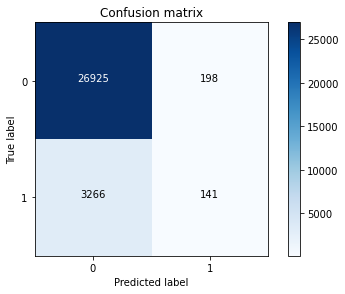

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_test_pred = lr.predict(X_te_bow)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = lr.predict_proba(X_te_bow)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))
print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Decision Tree with BoW

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dt.fit(X_tr_bow, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Roc-Auc : 0.58
Accuracy : 0.76
Precision : 0.17
Recall : 0.30
Macro f1 : 0.54


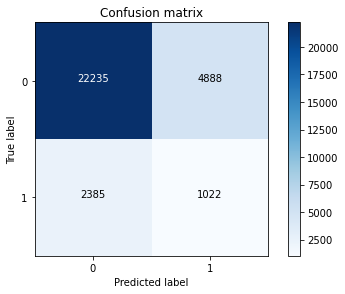

In [ ]:

y_test_pred = dt.predict(X_te_bow)

c_matrix_test = confusion_matrix(y_test, y_test_pred)
y_test_score = dt.predict_proba(X_te_bow)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Random Forest with BoW

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf.fit(X_tr_bow, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Roc-Auc : 0.69
Accuracy : 0.88
Precision : 0.30
Recall : 0.03
Macro f1 : 0.50


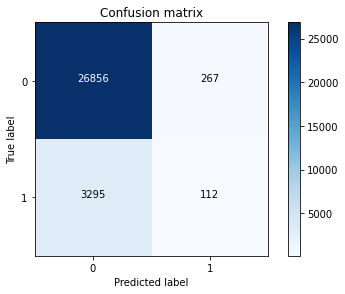

In [ ]:
y_test_pred = rf.predict(X_te_bow)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = rf.predict_proba(X_te_bow)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### XGBoost with BoW

Roc-Auc : 0.78
Accuracy : 0.89
Precision : 0.45
Recall : 0.03
Macro f1 : 0.50


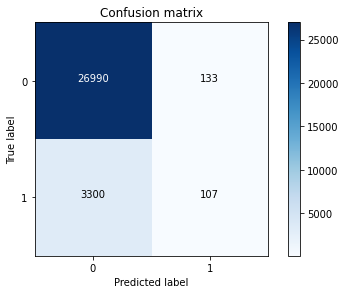

In [ ]:

xg = xgb.XGBClassifier(learning_rate=0.25, n_estimators=84)
xg.fit(X_tr_bow, y_train)

y_test_pred = xg.predict(X_te_bow)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = xg.predict_proba(X_te_bow)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Logistic Regression with Tfidf

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Roc-Auc : 0.71
Accuracy : 0.89
Precision : 0.42
Recall : 0.04
Macro f1 : 0.51


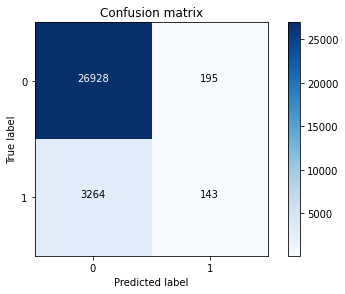

In [ ]:

lr = LogisticRegression(fit_intercept=True).fit(X_tr_tf, y_train)

y_test_pred = lr.predict(X_te_tf)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = lr.predict_proba(X_te_tf)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))
print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Decision Tree with Tfidf

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dt.fit(X_tr_tf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Roc-Auc : 0.58
Accuracy : 0.80
Precision : 0.18
Recall : 0.23
Macro f1 : 0.54


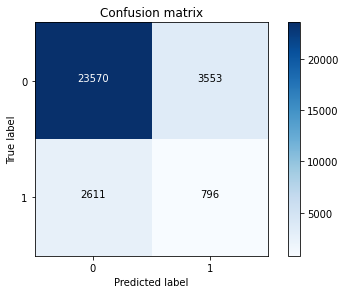

In [ ]:

y_test_pred = dt.predict(X_te_tf)

c_matrix_test = confusion_matrix(y_test, y_test_pred)
y_test_score = dt.predict_proba(X_te_tf)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### Random Forest with Tfidf

In [ ]:

rf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rf.fit(X_tr_tf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Roc-Auc : 0.68
Accuracy : 0.89
Precision : 0.33
Recall : 0.03
Macro f1 : 0.49


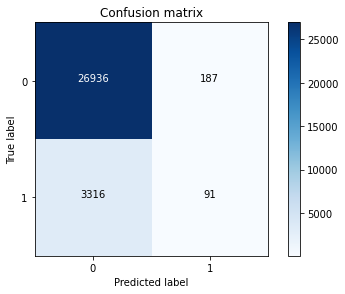

In [ ]:
y_test_pred = rf.predict(X_te_tf)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = rf.predict_proba(X_te_tf)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

### XGBoost with TfIDF

Roc-Auc : 0.78
Accuracy : 0.89
Precision : 0.44
Recall : 0.03
Macro f1 : 0.50


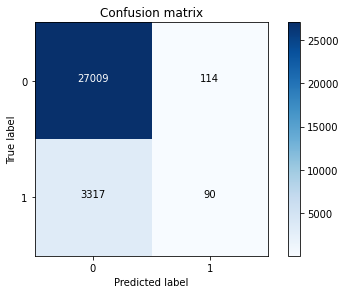

In [ ]:

xg = xgb.XGBClassifier(learning_rate=0.25, n_estimators=84)
xg.fit(X_tr_tf, y_train)

y_test_pred = xg.predict(X_te_tf)

c_matrix_test = confusion_matrix(y_test, y_test_pred)

y_test_score = xg.predict_proba(X_te_tf)[:,1]

print("Roc-Auc : {0:.2f}".format(roc_auc_score(y_test, y_test_score)))

print("Accuracy : {0:.2f}".format(accuracy_score(y_test, y_test_pred)))
print("Precision : {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recall : {0:.2f}".format(recall_score(y_test, y_test_pred)))
print("Macro f1 : {0:.2f}".format(f1_score(y_test, y_test_pred, average='macro')))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(c_matrix_test , classes=class_names, title='Confusion matrix')
plt.show()

#**LSTM and MLP**

In [20]:
X_train.head()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,procedure_per_med,num_med_up,num_med_used,count_encounter,gender_Female,gender_Male,gender_Unknown/Invalid,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,...,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,text
35582,85.0,1,3,7,3,43,0,9,0,0,0,9,4.777778,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,acute illdefined cerebrovascular disease cereb...
55196,65.0,1,1,7,2,66,1,13,0,0,1,9,5.153846,0,3,3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,septicemia acute kidney failure diabetes renal...
47517,75.0,1,1,7,2,43,0,16,0,0,0,7,2.687500,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,symptoms involving respiratory system chest sy...
91186,55.0,2,1,7,8,74,0,28,0,1,1,9,2.642857,0,3,3,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,pneumonia organism unspecified chronic bronchi...
42131,25.0,1,7,7,1,25,0,7,0,5,3,2,3.571429,1,1,12,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,diabetes ketoacidosis type juvenile type not s...


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

In [22]:
#loading our glove vector:
import pickle
with open('drive/MyDrive/glove_vectors', 'rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())

In [23]:
#https://keras.io/examples/nlp/pretrained_word_embeddings/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
vectorizer = TextVectorization(max_tokens=2000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(X_train['text']).batch(100)
vectorizer.adapt(text_ds)

In [24]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'care', 'discharged', 'home']

In [25]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [26]:
len(voc)

1220

In [27]:
#https://keras.io/examples/nlp/pretrained_word_embeddings/
embeddings_index = model
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0
# Preparing our embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
  # Words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 723 words (497 misses)


In [28]:

from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,Embedding, LSTM, Concatenate, Conv1D, BatchNormalization
from tensorflow.keras.models import Model
import random as rn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
import os
%reload_ext tensorboard
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
!rm -rf ./logs/
np.random.seed(0)
rn.seed(0)
batch_size=100
#for essay
input_txt = Input(shape=(None,), name='Text_input')
embedding_txt = Embedding(num_tokens,embedding_dim, 
                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                          trainable=False)(input_txt)
lstm_txt = LSTM(100)(embedding_txt)
flatten_txt = Flatten()(lstm_txt)

#for other features
input_others = Input(shape=(111,), name='others')
dense_others = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(input_others)


#final concatenation = text + categorical + numerical
input_final = Concatenate()([flatten_txt, dense_others])

#adding a dense layer:
dense1 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(input_final)
#adding a normalization layer:
norm1 = BatchNormalization()(dense1)
#another dense layer
dense2 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(norm1)
#another normalization layer:
norm2 = BatchNormalization()(dense2)
#final output layer:
output = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.HeNormal())(norm2)

model_1 = Model(inputs=[input_txt, input_others], outputs=output)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    366600      Text_input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          160400      embedding[0][0]                  
__________________________________________________________________________________________________
others (InputLayer)             [(None, 111)]        0                                            
______________________________________________________________________________________________

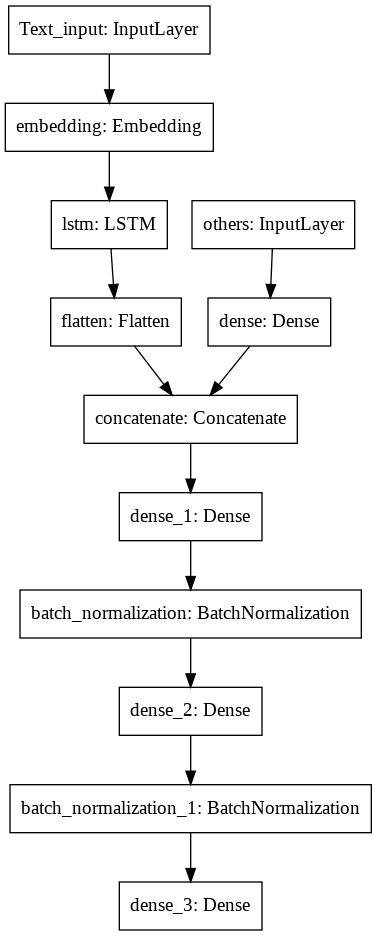

In [ ]:
tf.keras.utils.plot_model(model_1)

In [31]:
#creating a callback function for our model which finds AUC, Recall and f1_score:
import sklearn.metrics as sklm
from sklearn.metrics import roc_auc_score, f1_score, recall_score
class Metrics(tf.keras.callbacks.Callback):
  def __init__(self,tr_data, val_data):
    super().__init__()
    self.validation_data = val_data
    self.train_data = tr_data
  def on_train_begin(self, logs={}):
    self.auc_val = []
    self.auc_train = []
    self.recall_val = []
    self.recall_tr = []
    self.f1_val = []
    self.f1_tr = []

  def on_epoch_end(self, epoch, logs={}):
    score_val = np.asarray(self.model.predict(self.validation_data[0]))
    score_tr = np.asarray(self.model.predict(self.train_data[0]))
    predict_val = np.round(np.asarray(self.model.predict(self.validation_data[0])))
    predict_tr = np.round(np.asarray(self.model.predict(self.train_data[0])))
    targ_val = self.validation_data[1]
    targ_tr = self.train_data[1]
    self.auc_val.append(sklm.roc_auc_score(targ_val, score_val))
    self.auc_train.append(sklm.roc_auc_score(targ_tr, score_tr))
    self.recall_val.append(recall_score(targ_val, predict_val))
    self.recall_tr.append(recall_score(targ_tr, predict_tr))
    self.f1_val.append(f1_score(targ_val, predict_val, average='macro'))
    self.f1_tr.append(f1_score(targ_tr, predict_tr, average='macro'))
    return

In [32]:
#getting our final text features after vectorization:
X_tr_txt_lstm = vectorizer(np.array([[s] for s in X_train['text'].values])).numpy()
X_te_txt_lstm = vectorizer(np.array([[s] for s in X_test['text'].values])).numpy()


In [33]:
#stacking up all the features together into a dataframe:
X_tr_lstm = pd.DataFrame(np.hstack([X_tr_txt_lstm, X_train_categorical, X_train_age, X_train_time_in_hospital, X_train_num_lab_procedures,
                  X_train_num_procedures, X_train_num_medications, X_train_number_outpatient, X_train_number_emergency,
                  X_train_number_inpatient, X_train_number_diagnoses]))

X_te_lstm = pd.DataFrame(np.hstack([ X_te_txt_lstm, X_test_categorical, X_test_age, X_test_time_in_hospital, X_test_num_lab_procedures,
                  X_test_num_procedures, X_test_num_medications, X_test_number_outpatient, X_test_number_emergency,
                  X_test_number_inpatient, X_test_number_diagnoses])) 

    


In [ ]:
X_tr_lstm.shape

(71234, 161)

In [ ]:
X_te_lstm.shape

(30530, 161)

In [34]:


#slicing out the text features, categorical features and numerical features so as to match our model input:
X_tr_txt_lstm = X_tr_lstm.iloc[:,:50]
X_tr_others = X_tr_lstm.iloc[:,50:161]

X_te_txt_lstm = X_te_lstm.iloc[:,:50]
X_te_others = X_te_lstm.iloc[:,50:161]


In [37]:
#preparing our final input:
X_tr = [X_tr_txt_lstm, X_tr_others]
X_te = [ X_te_txt_lstm, X_te_others]

#adding the callback function of Metrics and finally compiling the model:
mc_callback = ModelCheckpoint(filepath='drive/MyDrive/model_1', save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callbacks = [Metrics((X_tr, y_train), (X_te, y_test)), mc_callback, es_callback]
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model_1.fit(X_tr, y_train, batch_size=100,epochs= 30, validation_data=(X_te, y_test), callbacks=callbacks )    


Epoch 1/30
713/713 [==============================] - 11s 12ms/step - loss: 0.6469 - accuracy: 0.6528 - val_loss: 0.4406 - val_accuracy: 0.8690


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 2/30
713/713 [==============================] - 8s 11ms/step - loss: 0.4059 - accuracy: 0.8777 - val_loss: 0.3360 - val_accuracy: 0.8861


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 3/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3247 - accuracy: 0.8884 - val_loss: 0.3200 - val_accuracy: 0.8873


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 4/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3134 - accuracy: 0.8889 - val_loss: 0.3174 - val_accuracy: 0.8876


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 5/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3126 - accuracy: 0.8884 - val_loss: 0.3163 - val_accuracy: 0.8875


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 6/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3169 - accuracy: 0.8862 - val_loss: 0.3151 - val_accuracy: 0.8877


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 7/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3125 - accuracy: 0.8886 - val_loss: 0.3150 - val_accuracy: 0.8871


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 8/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3123 - accuracy: 0.8878 - val_loss: 0.3231 - val_accuracy: 0.8872
Epoch 9/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3092 - accuracy: 0.8887 - val_loss: 0.3143 - val_accuracy: 0.8870


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 10/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3110 - accuracy: 0.8879 - val_loss: 0.3146 - val_accuracy: 0.8878
Epoch 11/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3105 - accuracy: 0.8869 - val_loss: 0.3131 - val_accuracy: 0.8869


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 12/30
713/713 [==============================] - 7s 10ms/step - loss: 0.3048 - accuracy: 0.8891 - val_loss: 0.3128 - val_accuracy: 0.8872


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_1/assets


Epoch 13/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3041 - accuracy: 0.8899 - val_loss: 0.3285 - val_accuracy: 0.8826
Epoch 14/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3061 - accuracy: 0.8884 - val_loss: 0.3151 - val_accuracy: 0.8878
Epoch 15/30
713/713 [==============================] - 8s 11ms/step - loss: 0.3080 - accuracy: 0.8883 - val_loss: 0.3163 - val_accuracy: 0.8870


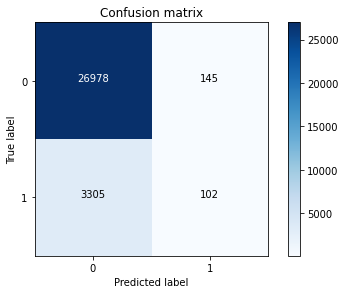

In [43]:
from sklearn.metrics import confusion_matrix
y_test_pred = np.round(np.asarray(model_1.predict(X_te)))
cm1=confusion_matrix(y_test,y_test_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm1 , classes=class_names, title='Confusion matrix')
plt.show()

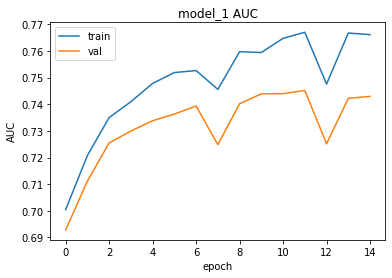

In [39]:
import matplotlib.pyplot as plt

auc_train = callbacks[0].auc_train
auc_val = callbacks[0].auc_val
plt.plot(list(range(15)), auc_train)
plt.plot(list(range(15)), auc_val)
plt.title('model_1 AUC')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.show()

In [44]:
callbacks[0].auc_val

[0.6928074543193802,
 0.7111285345550102,
 0.7254964152964967,
 0.7299449070790481,
 0.7338074705409087,
 0.7363267475117783,
 0.7393466139279774,
 0.7248248342750099,
 0.7401733437519048,
 0.7439276807247367,
 0.7439777791679884,
 0.745182619944812,
 0.725139817618292,
 0.7422219529094978,
 0.7429587771568976]

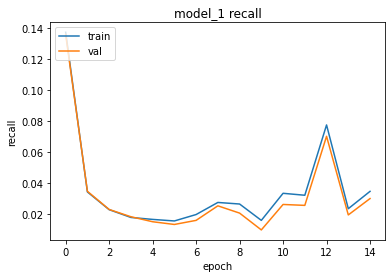

In [46]:

recall_tr = callbacks[0].recall_tr
recall_val = callbacks[0].recall_val
plt.plot(list(range(15)), recall_tr)
plt.plot(list(range(15)), recall_val)
plt.title('model_1 recall')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

In [47]:
callbacks[0].recall_val

[0.1358966832990901,
 0.034634575873202234,
 0.02289404167889639,
 0.018197828001174053,
 0.014969181097739948,
 0.013208100968594072,
 0.015849721162312886,
 0.025242148517757558,
 0.02054593484003522,
 0.00968594071030232,
 0.026122688582330494,
 0.025535661872615203,
 0.0701496918109774,
 0.01937188142060464,
 0.029938362195479896]

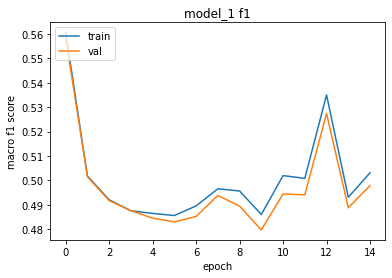

In [48]:
f1_tr = callbacks[0].f1_tr
f1_val = callbacks[0].f1_val
plt.plot(list(range(15)), f1_tr)
plt.plot(list(range(15)), f1_val)
plt.title('model_1 f1')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('macro f1 score')
plt.xlabel('epoch')
plt.show()

In [49]:
callbacks[0].f1_val

[0.5583906635517442,
 0.5014825923641025,
 0.4917284824179138,
 0.4875939182476981,
 0.48454809012636435,
 0.48301726429937936,
 0.48521856657483836,
 0.49382196958615887,
 0.4894682944075249,
 0.47971787677938355,
 0.494431966754617,
 0.4940683696635839,
 0.527374505778942,
 0.4887739071451852,
 0.4978654903365405]

# Model-2 (LSTM-Conv1D)

In [50]:
import os
%reload_ext tensorboard
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
!rm -rf ./logs/
np.random.seed(0)
rn.seed(0)
batch_size=100
#for essay
input_txt = Input(shape=(None,), name='Text_input')
embedding_txt = Embedding(num_tokens,embedding_dim, 
                          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                          trainable=False)(input_txt)
lstm_txt = LSTM(100)(embedding_txt)
flatten_txt = Flatten()(lstm_txt)

#for categorical
input_cat = Input(shape=(102,1), name='categorical')
conv_cat1 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_cat1')(input_cat)
norm_cat1 = BatchNormalization()(conv_cat1)
conv_cat2 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_cat2')(norm_cat1)
norm_cat2 = BatchNormalization()(conv_cat2)
flatten_cat = Flatten()(norm_cat2)

#dense_cat = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(conv_cat)

#for numerical
input_num = Input(shape=(9,1), name='numerical')
conv_num1 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_num1')(input_num)
norm_num1 = BatchNormalization()(conv_num1)
conv_num2 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_num2')(norm_num1)
norm_num2 = BatchNormalization()(conv_num2)
flatten_num = Flatten()(norm_num2)
#dense_num = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(conv_num)

#final concatenation = text + categorical + numerical
input_final = Concatenate()([flatten_txt, flatten_cat, flatten_num])

#adding a dense layer:
dense1 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(input_final)
#adding a normalization layer:
norm1 = BatchNormalization()(dense1)
#another dense layer
dense2 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(norm1)
#another normalization layer:
norm2 = BatchNormalization()(dense2)

#another dense layer
dense3 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(norm2)
#another dense layer
dense4 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(dense3)
#final output layer:
output = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.HeNormal())(dense4)

model_2 = Model(inputs=[input_txt, input_cat, input_num], outputs=output)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical (InputLayer)        [(None, 102, 1)]     0                                            
__________________________________________________________________________________________________
numerical (InputLayer)          [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
conv_cat1 (Conv1D)              (None, 102, 64)      256         categorical[0][0]                
__________________________________________________________________________________________________
conv_num1 (Conv1D)              (None, 9, 64)        256         numerical[0][0]                  
______________________________________________________________________________________________

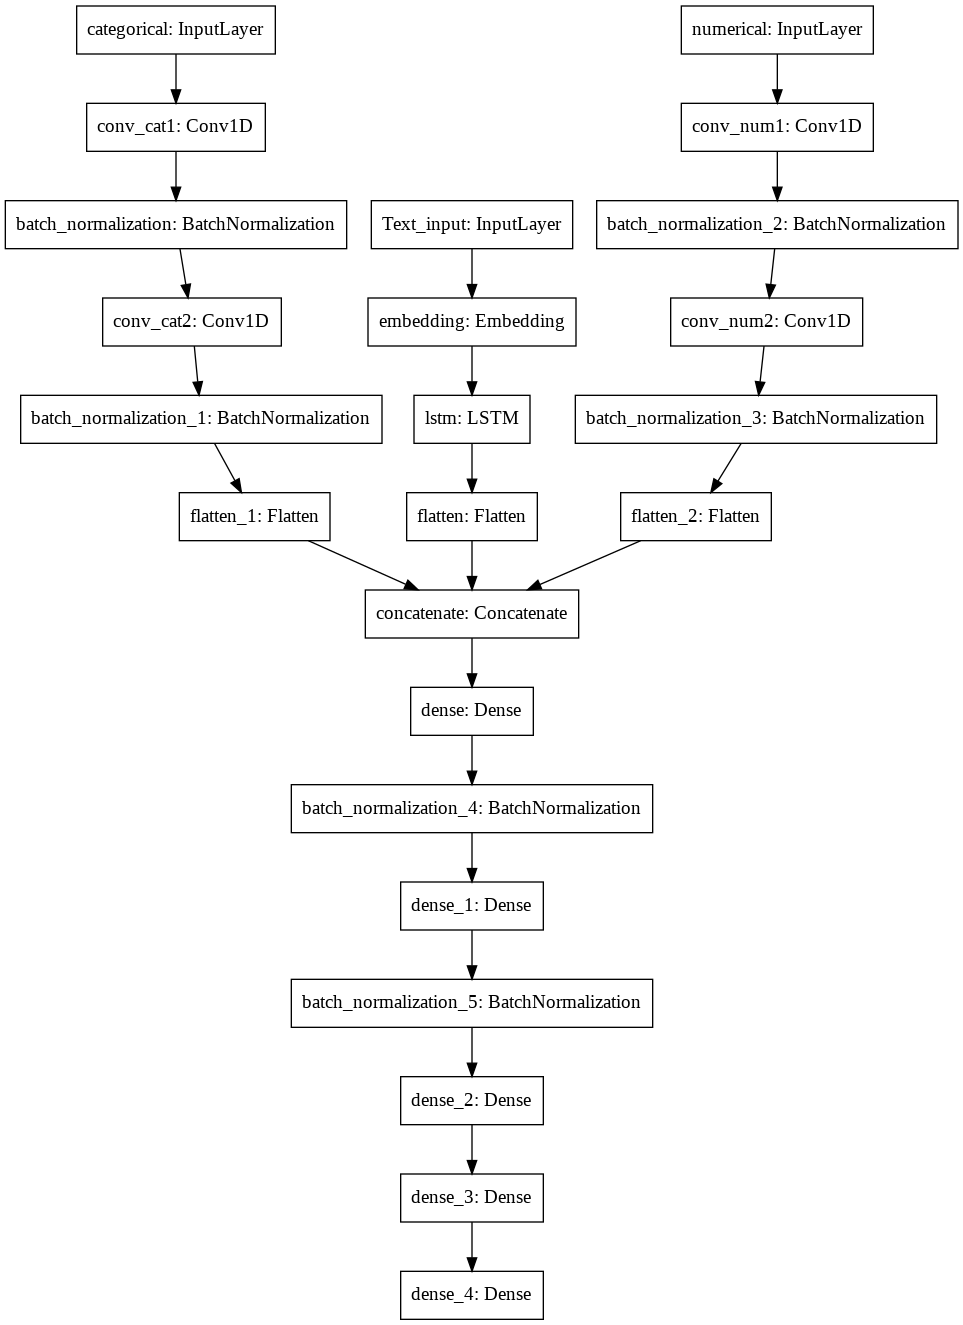

In [ ]:
tf.keras.utils.plot_model(model_2)

In [54]:


#slicing out the text features, categorical features and numerical features so as to match our model input:
X_tr_txt_lstm = X_tr_lstm.iloc[:,:50]
X_tr_categorical = X_tr_lstm.iloc[:,50:152]
X_tr_num = X_tr_lstm.iloc[:,152:161]

X_te_txt_lstm = X_te_lstm.iloc[:,:50]
X_te_categorical = X_te_lstm.iloc[:,50:152]
X_te_num = X_te_lstm.iloc[:,152:161]


In [56]:
#preparing our final input:
X_tr = [X_tr_txt_lstm, X_tr_categorical, X_tr_num]
X_te = [ X_te_txt_lstm, X_te_categorical,X_te_num]

#adding the callback function of Metrics and finally compiling the model:
mc_callback = ModelCheckpoint(filepath='drive/MyDrive/model_2', save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callbacks = [Metrics((X_tr, y_train), (X_te, y_test)), mc_callback, es_callback]
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model_2.fit(X_tr, y_train, batch_size=100,epochs= 30, validation_data=(X_te, y_test), callbacks=callbacks ) 

Epoch 1/30
713/713 [==============================] - 14s 15ms/step - loss: 0.3368 - accuracy: 0.8866 - val_loss: 0.3248 - val_accuracy: 0.8884


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


Epoch 2/30
713/713 [==============================] - 10s 14ms/step - loss: 0.3137 - accuracy: 0.8864 - val_loss: 0.3128 - val_accuracy: 0.8874


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


Epoch 3/30
713/713 [==============================] - 10s 14ms/step - loss: 0.3038 - accuracy: 0.8898 - val_loss: 0.3120 - val_accuracy: 0.8877


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


Epoch 4/30
713/713 [==============================] - 10s 14ms/step - loss: 0.2968 - accuracy: 0.8903 - val_loss: 0.3082 - val_accuracy: 0.8877


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_2/assets


Epoch 5/30
713/713 [==============================] - 9s 13ms/step - loss: 0.2975 - accuracy: 0.8898 - val_loss: 0.3137 - val_accuracy: 0.8864
Epoch 6/30
713/713 [==============================] - 10s 14ms/step - loss: 0.2988 - accuracy: 0.8872 - val_loss: 0.3082 - val_accuracy: 0.8869
Epoch 7/30
713/713 [==============================] - 10s 14ms/step - loss: 0.2926 - accuracy: 0.8904 - val_loss: 0.3111 - val_accuracy: 0.8864


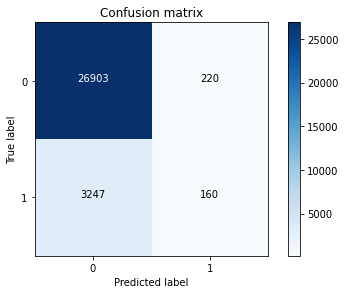

In [57]:
from sklearn.metrics import confusion_matrix
y_test_pred = np.round(np.asarray(model_2.predict(X_te)))
cm2=confusion_matrix(y_test,y_test_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm2 , classes=class_names, title='Confusion matrix')
plt.show()

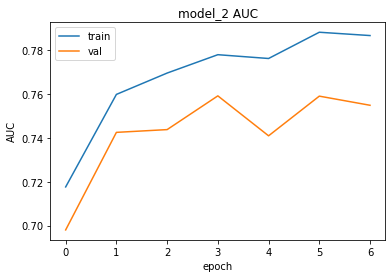

In [58]:
import matplotlib.pyplot as plt

auc_train = callbacks[0].auc_train
auc_val = callbacks[0].auc_val
plt.plot(list(range(7)), auc_train)
plt.plot(list(range(7)), auc_val)
plt.title('model_2 AUC')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.show()

In [59]:
callbacks[0].auc_val

[0.6979922887896112,
 0.7425498301495581,
 0.7438107807499609,
 0.7592220661355507,
 0.7409770290494463,
 0.7590978020846039,
 0.7549234530524345]

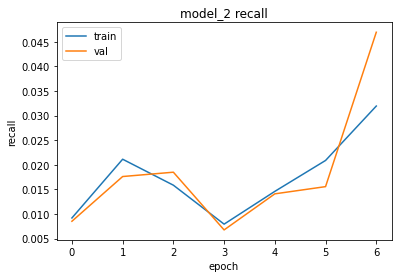

In [60]:

recall_tr = callbacks[0].recall_tr
recall_val = callbacks[0].recall_val
plt.plot(list(range(7)), recall_tr)
plt.plot(list(range(7)), recall_val)
plt.title('model_2 recall')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

In [61]:
callbacks[0].recall_val

[0.008511887290871734,
 0.017610801291458762,
 0.0184913413560317,
 0.0067508071617258586,
 0.01408864103316701,
 0.015556207807455239,
 0.046962136777223364]

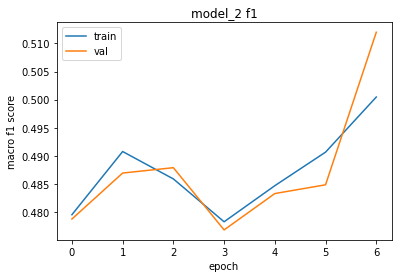

In [62]:
f1_tr = callbacks[0].f1_tr
f1_val = callbacks[0].f1_val
plt.plot(list(range(7)), f1_tr)
plt.plot(list(range(7)), f1_val)
plt.title('model_2 f1')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('macro f1 score')
plt.xlabel('epoch')
plt.show()

In [63]:
callbacks[0].f1_val

[0.47878057840103677,
 0.48695484040569775,
 0.4879067202741864,
 0.476845326551991,
 0.48330939373794524,
 0.4848662587731533,
 0.51198248576667]

# MLP (Without Text)

In [64]:
import os
%reload_ext tensorboard
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
!rm -rf ./logs/
np.random.seed(0)
rn.seed(0)
batch_size=100

#for categorical
input_cat = Input(shape=(102,1), name='categorical')
conv_cat1 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_cat1')(input_cat)
norm_cat1 = BatchNormalization()(conv_cat1)
conv_cat2 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_cat2')(norm_cat1)
norm_cat2 = BatchNormalization()(conv_cat2)
flatten_cat = Flatten()(norm_cat1)

#dense_cat = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(conv_cat)

#for numerical
input_num = Input(shape=(9,1), name='numerical')
conv_num1 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_num1')(input_num)
norm_num1 = BatchNormalization()(conv_num1)
conv_num2 = Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',name='conv_num2')(norm_num1)
norm_num2 = BatchNormalization()(conv_num1)
flatten_num = Flatten()(norm_num2)
#dense_num = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(conv_num)

#final concatenation = categorical + numerical
input_final = Concatenate()([flatten_cat, flatten_num])

#adding a dense layer:
dense1 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(input_final)
#adding a normalization layer:
norm1 = BatchNormalization()(dense1)
#another dense layer
dense2 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(norm1)
#another normalization layer:
norm2 = BatchNormalization()(dense2)

#another dense layer
dense3 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(norm2)
#another dense layer
dense4 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(dense3)
#final output layer:
dense5 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(dense4)
dense6 = Dense(64,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(dense5)
output = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.HeNormal())(dense6)

model_3 = Model(inputs=[input_cat, input_num], outputs=output)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical (InputLayer)        [(None, 102, 1)]     0                                            
__________________________________________________________________________________________________
numerical (InputLayer)          [(None, 9, 1)]       0                                            
__________________________________________________________________________________________________
conv_cat1 (Conv1D)              (None, 102, 64)      256         categorical[0][0]                
__________________________________________________________________________________________________
conv_num1 (Conv1D)              (None, 9, 64)        256         numerical[0][0]                  
______________________________________________________________________________________________

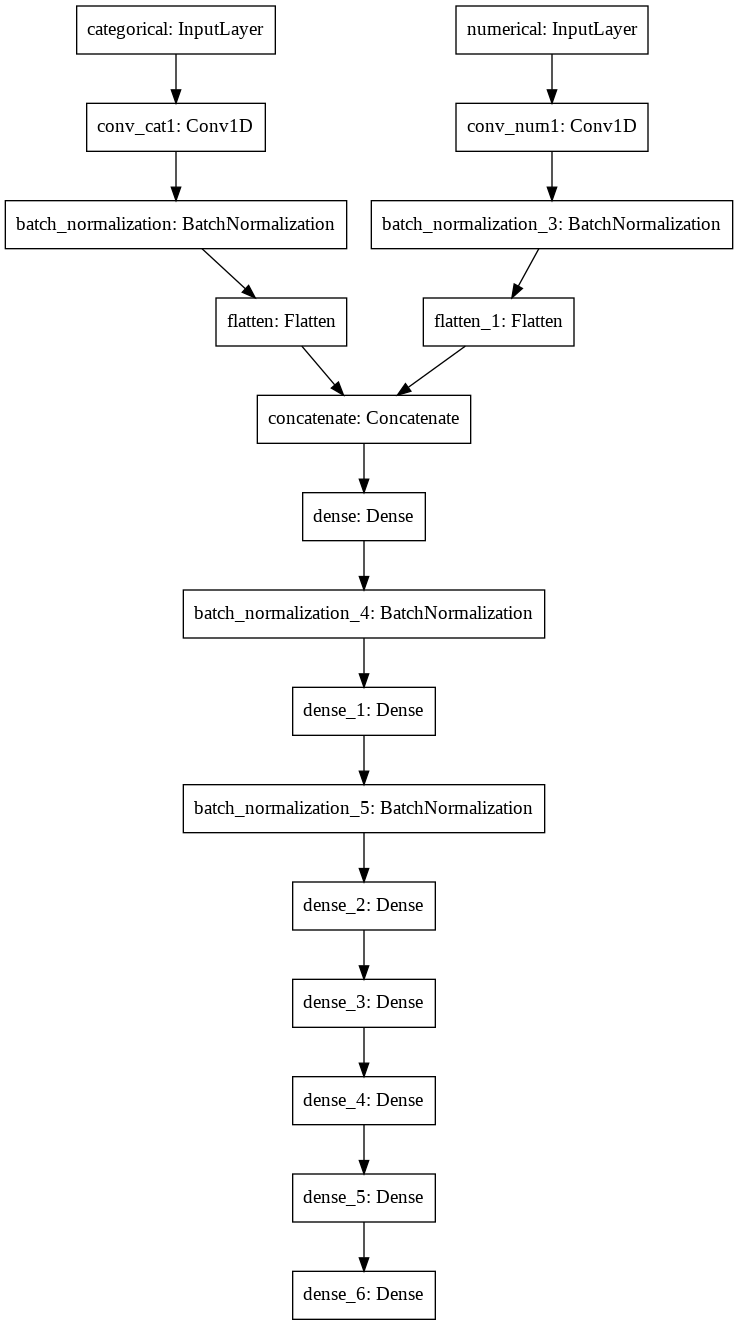

In [ ]:
tf.keras.utils.plot_model(model_3)

In [65]:
#stacking up all the features together into a dataframe:
X_tr_mlp = pd.DataFrame(np.hstack([X_train_categorical, X_train_age, X_train_time_in_hospital, X_train_num_lab_procedures,
                  X_train_num_procedures, X_train_num_medications, X_train_number_outpatient, X_train_number_emergency,
                  X_train_number_inpatient, X_train_number_diagnoses]))

X_te_mlp = pd.DataFrame(np.hstack([ X_test_categorical, X_test_age, X_test_time_in_hospital, X_test_num_lab_procedures,
                  X_test_num_procedures, X_test_num_medications, X_test_number_outpatient, X_test_number_emergency,
                  X_test_number_inpatient, X_test_number_diagnoses])) 

    


In [ ]:
X_tr_mlp.shape

(71234, 111)

In [66]:
#https://www.kaggle.com/qianchao/smote-with-imbalance-data
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_tr_mlp, y_train.ravel())


print('After SMOTE, the shape of train_X: {}'.format(X_train_res.shape))
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After SMOTE, counts of label '1': {}".format(sum(y_train_res==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 7950
Before OverSampling, counts of label '0': 63284 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE, the shape of train_X: (126568, 111)
After SMOTE, the shape of train_y: (126568,) 

After SMOTE, counts of label '1': 63284
After SMOTE, counts of label '0': 63284


In [ ]:
X_train_res.shape

(126568, 111)

In [67]:


#slicing out the text features, categorical features and numerical features so as to match our model input:

X_tr_categorical = X_train_res[:,:102]
X_tr_num = X_train_res[:,102:111]

X_te_categorical = X_te_mlp.iloc[:,:102]
X_te_num = X_te_mlp.iloc[:,102:111]

In [69]:
#preparing our final input:
X_tr = [X_tr_categorical, X_tr_num]
X_te = [X_te_categorical, X_te_num]

#adding the callback function of Metrics and finally compiling the model:
mc_callback = ModelCheckpoint(filepath='drive/MyDrive/model_3', save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callbacks = [Metrics((X_tr, y_train_res), (X_te, y_test)), mc_callback, es_callback]

model_3.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model_3.fit(X_tr, y_train_res, batch_size=100,epochs= 30, validation_data=(X_te, y_test), callbacks=callbacks ) 

Epoch 1/30
1266/1266 [==============================] - 9s 6ms/step - loss: 0.5712 - accuracy: 0.6970 - val_loss: 0.7046 - val_accuracy: 0.5952
INFO:tensorflow:Assets written to: drive/MyDrive/model_3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_3/assets


Epoch 2/30
1266/1266 [==============================] - 8s 6ms/step - loss: 0.4104 - accuracy: 0.7910 - val_loss: 2.1072 - val_accuracy: 0.2301
Epoch 3/30
1266/1266 [==============================] - 8s 6ms/step - loss: 0.3908 - accuracy: 0.8047 - val_loss: 0.3865 - val_accuracy: 0.8226
INFO:tensorflow:Assets written to: drive/MyDrive/model_3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_3/assets


Epoch 4/30
1266/1266 [==============================] - 8s 6ms/step - loss: 0.3722 - accuracy: 0.8142 - val_loss: 0.4126 - val_accuracy: 0.7841
Epoch 5/30
1266/1266 [==============================] - 8s 6ms/step - loss: 0.3653 - accuracy: 0.8181 - val_loss: 0.4458 - val_accuracy: 0.7622
Epoch 6/30
1266/1266 [==============================] - 8s 7ms/step - loss: 0.3566 - accuracy: 0.8228 - val_loss: 0.4111 - val_accuracy: 0.8198


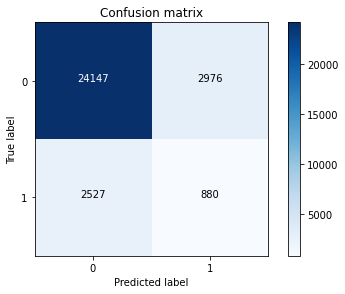

In [71]:
from sklearn.metrics import confusion_matrix
y_test_pred = np.round(np.asarray(model_3.predict(X_te)))
cm3=confusion_matrix(y_test,y_test_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm3 , classes=class_names, title='Confusion matrix')
plt.show()

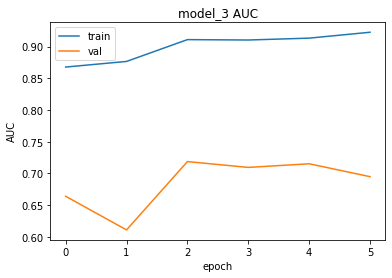

In [73]:
import matplotlib.pyplot as plt

auc_train = callbacks[0].auc_train
auc_val = callbacks[0].auc_val
plt.plot(list(range(6)), auc_train)
plt.plot(list(range(6)), auc_val)
plt.title('model_3 AUC')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.show()

In [74]:
callbacks[0].auc_val

[0.664125649168204,
 0.6111251971838257,
 0.7187482269539234,
 0.7095866019740421,
 0.7153080184206007,
 0.6950029391916361]

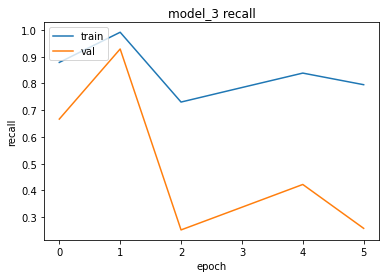

In [75]:

recall_tr = callbacks[0].recall_tr
recall_val = callbacks[0].recall_val
plt.plot(list(range(6)), recall_tr)
plt.plot(list(range(6)), recall_val)
plt.title('model_3 recall')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

In [76]:
callbacks[0].recall_val

[0.6668623422365718,
 0.9289697681244496,
 0.25242148517757557,
 0.3372468447314353,
 0.4223657176401526,
 0.2582917522747285]

In [ ]:
np.mean(callbacks[0].recall_val)

0.2956266510126211

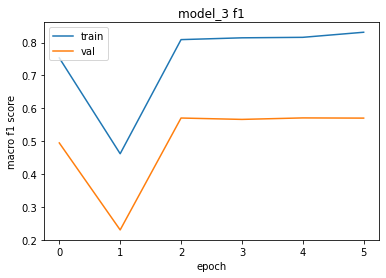

In [77]:
f1_tr = callbacks[0].f1_tr
f1_val = callbacks[0].f1_val
plt.plot(list(range(6)), f1_tr)
plt.plot(list(range(6)), f1_val)
plt.title('model_3 f1')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('macro f1 score')
plt.xlabel('epoch')
plt.show()

In [78]:
callbacks[0].f1_val

[0.49447017258318016,
 0.22967073104085234,
 0.5702697787394758,
 0.5660936073993235,
 0.5706304972380155,
 0.5700160795649529]

# Model_4 (Simple MLP)

In [79]:
import os
%reload_ext tensorboard
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
!rm -rf ./logs/
np.random.seed(0)
rn.seed(0)
batch_size=100

#final concatenation = categorical + numerical
input = Input(shape=(111,), name='input')

#adding a dense layer:
dense1 = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(input)
#adding a normalization layer:
norm1 = BatchNormalization()(dense1)
#another dense layer
dense2 = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(norm1)
#another normalization layer:
norm2 = BatchNormalization()(dense2)

#another dense layer
dense3 = Dense(16,activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal())(norm2)
#another dense layer
dense4 = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(dense3)
#final output layer:
dense5 = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(dense4)
dense6 = Dense(16,activation='relu', kernel_initializer=tf.keras.initializers.HeNormal())(dense5)


output = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal())(norm2)

model_4 = Model(inputs=input, outputs=output)
model_4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 111)]             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 2,209
Trainable params: 2,145
Non-trainable params: 64
__________________________________________________________

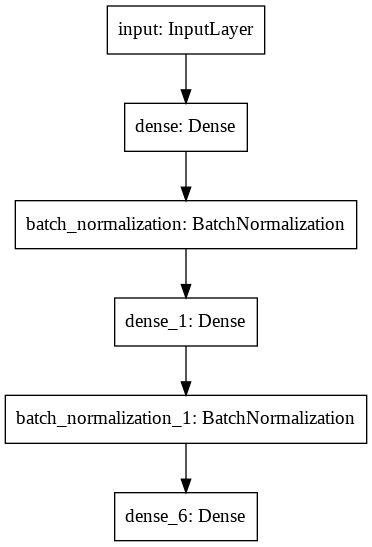

In [ ]:
tf.keras.utils.plot_model(model_4)

In [80]:

#adding the callback function of Metrics and finally compiling the model:
mc_callback = ModelCheckpoint(filepath='drive/MyDrive/model_4', save_best_only=True)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callbacks = [Metrics((X_train_res, y_train_res), (X_te_mlp, y_test)), mc_callback, es_callback]

model_4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])
model_4.fit(X_train_res, y_train_res, batch_size=50,epochs= 30, validation_data=(X_te_mlp, y_test), callbacks=callbacks ) 

Epoch 1/30
2532/2532 [==============================] - 11s 4ms/step - loss: 0.7460 - accuracy: 0.5760 - val_loss: 0.6455 - val_accuracy: 0.6637
INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


Epoch 2/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.6148 - accuracy: 0.6688 - val_loss: 0.6227 - val_accuracy: 0.6710
INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


Epoch 3/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.5975 - accuracy: 0.6851 - val_loss: 0.6155 - val_accuracy: 0.6581
INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


Epoch 4/30
2532/2532 [==============================] - 9s 4ms/step - loss: 0.5927 - accuracy: 0.6904 - val_loss: 0.6245 - val_accuracy: 0.6418
Epoch 5/30
2532/2532 [==============================] - 9s 4ms/step - loss: 0.5877 - accuracy: 0.6935 - val_loss: 0.6144 - val_accuracy: 0.6353
INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


Epoch 6/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.5838 - accuracy: 0.6953 - val_loss: 0.6106 - val_accuracy: 0.6373
INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


Epoch 7/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.5804 - accuracy: 0.6990 - val_loss: 0.6238 - val_accuracy: 0.6236
Epoch 8/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.5793 - accuracy: 0.6995 - val_loss: 0.6257 - val_accuracy: 0.6203
Epoch 9/30
2532/2532 [==============================] - 9s 4ms/step - loss: 0.5748 - accuracy: 0.7043 - val_loss: 0.6030 - val_accuracy: 0.6279
INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/model_4/assets


Epoch 10/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.5736 - accuracy: 0.7037 - val_loss: 0.6237 - val_accuracy: 0.6164
Epoch 11/30
2532/2532 [==============================] - 9s 4ms/step - loss: 0.5706 - accuracy: 0.7084 - val_loss: 0.6227 - val_accuracy: 0.6114
Epoch 12/30
2532/2532 [==============================] - 10s 4ms/step - loss: 0.5712 - accuracy: 0.7068 - val_loss: 0.6068 - val_accuracy: 0.6196


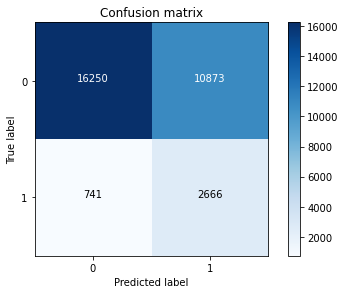

In [82]:
from sklearn.metrics import confusion_matrix
y_test_pred = np.round(np.asarray(model_4.predict(X_te_mlp)))
cm4=confusion_matrix(y_test,y_test_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm4 , classes=class_names, title='Confusion matrix')
plt.show()

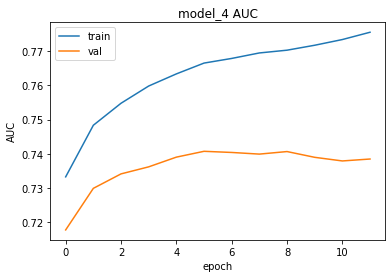

In [84]:
import matplotlib.pyplot as plt

auc_train = callbacks[0].auc_train
auc_val = callbacks[0].auc_val
plt.plot(list(range(12)), auc_train)
plt.plot(list(range(12)), auc_val)
plt.title('model_4 AUC')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.show()

In [85]:
callbacks[0].auc_val

[0.7177887381491533,
 0.7299277494849719,
 0.7341462396878992,
 0.7362040038909594,
 0.7390379828443755,
 0.7407406481562252,
 0.7404058342918807,
 0.7399243773765583,
 0.7406670398592174,
 0.7389857741956084,
 0.7379265917071889,
 0.738489718986745]

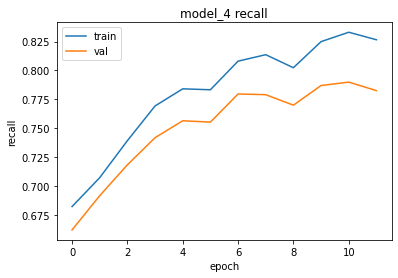

In [86]:

recall_tr = callbacks[0].recall_tr
recall_val = callbacks[0].recall_val
plt.plot(list(range(12)), recall_tr)
plt.plot(list(range(12)), recall_val)
plt.title('model_4 recall')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

In [87]:
callbacks[0].recall_val

[0.6618726152039918,
 0.691517464044614,
 0.7182271793366598,
 0.7417082477252716,
 0.7563839154681538,
 0.7552098620487232,
 0.7795714705019078,
 0.7789844437921926,
 0.7698855297916055,
 0.7869093043733489,
 0.7898444379219255,
 0.7825066040504843]

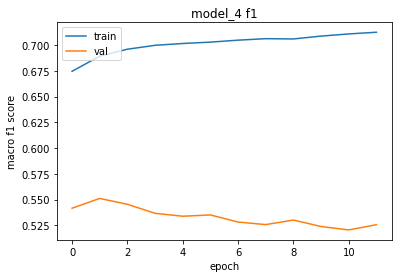

In [88]:
f1_tr = callbacks[0].f1_tr
f1_val = callbacks[0].f1_val
plt.plot(list(range(12)), f1_tr)
plt.plot(list(range(12)), f1_val)
plt.title('model_4 f1')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('macro f1 score')
plt.xlabel('epoch')
plt.show()

In [89]:
callbacks[0].f1_val

[0.5416865617288401,
 0.5511827525105611,
 0.545493289406503,
 0.5367375547492167,
 0.5338971892502395,
 0.5351715073841294,
 0.5282693789388276,
 0.5257914201183431,
 0.5302060611553265,
 0.5239362854690114,
 0.520622118378097,
 0.525687046866294]

# Summary

In [ ]:
from tabulate import tabulate
print(tabulate([['Log. Reg. without Text (SMOTE)',0.70,0.73, 0.55, 0.57],['Decision Tree without Text',0.48,0.25, 0.79, 0.25],
                ['Random Forest without Text (SMOTE)',0.66,0.79,0.28, 0.56],
               ['XGBoost without Text (SMOTE)', 0.61, 0.43,  0.77, 0.39],
               ['Log Reg with text (BoW,No SMOTE)', 0.71,0.89,0.04, 0.51],
               ['Decision Tree with text (BoW, No SMOTE)', 0.58, 0.76,0.30, 0.54],
               ['Random Forest with text (BoW, No SMOTE)', 0.69, 0.88,0.03, 0.50],
               ['XGBoost with text (BoW, No SMOTE)', 0.78,0.89,0.03, 0.50],
               ['Log Reg with text (TfIDF, No SMOTE)', 0.71,0.89,0.04, 0.51],
               ['Decision Tree with text (TfIDF, No SMOTE)', 0.58,0.80,0.23, 0.54],
               ['Random Forest with text (TfIDF, No SMOTE)', 0.68, 0.89,0.03, 0.49],
               ['XGBoost with text (TfIDF, No SMOTE)', 0.78,0.89,0.03, 0.50],
               ['LSTM Model_1 with text (No SMOTE)', 0.74,0.89,0.14, 0.56],
               ['LSTM-Conv1D Model_2 with text (No SMOTE)', 0.76,0.89,0.06, 0.52],
               ['Conv1D Model_3 without text (SMOTE)', 0.75,0.88,0.36, 0.57],
               ['Simple MLP Model_4 without text (SMOTE)', 0.74,0.67,0.79, 0.55]],
headers=['Model','roc_auc_score','accuracy','recall', 'macro-f1'], tablefmt='orgtbl'))

| Model                                     |   roc_auc_score |   accuracy |   recall |   macro-f1 |
|-------------------------------------------+-----------------+------------+----------+------------|
| Log. Reg. without Text (SMOTE)            |            0.7  |       0.73 |     0.55 |       0.57 |
| Decision Tree without Text                |            0.48 |       0.25 |     0.79 |       0.25 |
| Random Forest without Text (SMOTE)        |            0.66 |       0.79 |     0.28 |       0.56 |
| XGBoost without Text (SMOTE)              |            0.61 |       0.43 |     0.77 |       0.39 |
| Log Reg with text (BoW,No SMOTE)          |            0.71 |       0.89 |     0.04 |       0.51 |
| Decision Tree with text (BoW, No SMOTE)   |            0.58 |       0.76 |     0.3  |       0.54 |
| Random Forest with text (BoW, No SMOTE)   |            0.69 |       0.88 |     0.03 |       0.5  |
| XGBoost with text (BoW, No SMOTE)         |            0.78 |       0.89 |     0.03 |    

# Conclusion:
* I should focus on recall score as our metric because it is a medical issue.
* But since data is unbalanced I cannot ignore macro F1 score. 
* When it is about recall, it is a tie between Decision Tree without Text and Simple MLP Model_4 without text (SMOTE). 
* when it is about f1_score, it is a tie between Log. Reg. without Text (SMOTE)  and Conv1D Model_3 without text (SMOTE).
* Overall, considering f1 as our main metric, Log. Reg. without Text (SMOTE) is the best model.